In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from numba import jit, float64, int64

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../_00_data/Sepulveda2020_value_prep.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(7289, 5) (7289, 5)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 111       
                                                                 
Total params: 479 (1.87 KB)
Trainable params: 479 (1.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/3500
1/1 [==============================] - 1s 570ms/step - loss: 60050.4297
Epoch 2/3500
1/1 [==============================] - 0s 3ms/step - loss: 59689.6094
Epoch 3/3500
1/1 [==============================] - 0s 3ms/step - loss: 59418.2852
Epoch 4/3500
1/1 [==============================] - 0s 4ms/step - loss: 59182.9219
Epoch 5/3500
1/1 [==============================] - 0s 4ms/step - loss: 58968.9453
Epoch 6/3500
1/1 [==============================] - 0s 3ms/step - loss: 58769.8203
Epoch 7/3500
1/1 [==============================] - 0s 3ms/step - loss: 58581.9062
Epoch 8/3500
1/1 [==============================] - 0s 3ms/step - loss: 58402.9570
Epoch 9/3500
1/1 [==============================] - 0s 4ms/step - loss: 58231.4688
Epoch 10/3500
1/1 [==============================] - 0s 3ms/step - loss: 58066.3359
Epoch 11/3500
1/1 [==============================] - 0s 3ms/step - loss: 57906.7578
Epoch 12/3500
1/1 [==============================] - 0s 3ms/step - loss: 57752.0547

1/1 [==============================] - 0s 4ms/step - loss: 50375.7461
Epoch 99/3500
1/1 [==============================] - 0s 4ms/step - loss: 50321.7930
Epoch 100/3500
1/1 [==============================] - 0s 4ms/step - loss: 50268.3359
Epoch 101/3500
1/1 [==============================] - 0s 4ms/step - loss: 50215.3750
Epoch 102/3500
1/1 [==============================] - 0s 3ms/step - loss: 50162.8984
Epoch 103/3500
1/1 [==============================] - 0s 4ms/step - loss: 50110.9062
Epoch 104/3500
1/1 [==============================] - 0s 4ms/step - loss: 50059.3906
Epoch 105/3500
1/1 [==============================] - 0s 3ms/step - loss: 50008.3594
Epoch 106/3500
1/1 [==============================] - 0s 3ms/step - loss: 49957.7773
Epoch 107/3500
1/1 [==============================] - 0s 4ms/step - loss: 49907.6562
Epoch 108/3500
1/1 [==============================] - 0s 4ms/step - loss: 49857.9922
Epoch 109/3500
1/1 [==============================] - 0s 3ms/step - loss: 49808.7

1/1 [==============================] - 0s 3ms/step - loss: 46737.4688
Epoch 195/3500
1/1 [==============================] - 0s 4ms/step - loss: 46710.0625
Epoch 196/3500
1/1 [==============================] - 0s 3ms/step - loss: 46682.7891
Epoch 197/3500
1/1 [==============================] - 0s 4ms/step - loss: 46655.6406
Epoch 198/3500
1/1 [==============================] - 0s 4ms/step - loss: 46628.6211
Epoch 199/3500
1/1 [==============================] - 0s 3ms/step - loss: 46601.7383
Epoch 200/3500
1/1 [==============================] - 0s 4ms/step - loss: 46574.9805
Epoch 201/3500
1/1 [==============================] - 0s 4ms/step - loss: 46548.3438
Epoch 202/3500
1/1 [==============================] - 0s 4ms/step - loss: 46521.8281
Epoch 203/3500
1/1 [==============================] - 0s 4ms/step - loss: 46495.4453
Epoch 204/3500
1/1 [==============================] - 0s 4ms/step - loss: 46469.1797
Epoch 205/3500
1/1 [==============================] - 0s 4ms/step - loss: 46443.

1/1 [==============================] - 0s 4ms/step - loss: 44542.3281
Epoch 291/3500
1/1 [==============================] - 0s 4ms/step - loss: 44522.7500
Epoch 292/3500
1/1 [==============================] - 0s 4ms/step - loss: 44503.2266
Epoch 293/3500
1/1 [==============================] - 0s 4ms/step - loss: 44483.7422
Epoch 294/3500
1/1 [==============================] - 0s 4ms/step - loss: 44464.3125
Epoch 295/3500
1/1 [==============================] - 0s 4ms/step - loss: 44444.9219
Epoch 296/3500
1/1 [==============================] - 0s 4ms/step - loss: 44425.5820
Epoch 297/3500
1/1 [==============================] - 0s 4ms/step - loss: 44406.2891
Epoch 298/3500
1/1 [==============================] - 0s 4ms/step - loss: 44387.0391
Epoch 299/3500
1/1 [==============================] - 0s 3ms/step - loss: 44367.8320
Epoch 300/3500
1/1 [==============================] - 0s 4ms/step - loss: 44348.6680
Epoch 301/3500
1/1 [==============================] - 0s 4ms/step - loss: 44329.

1/1 [==============================] - 0s 3ms/step - loss: 42835.4570
Epoch 387/3500
1/1 [==============================] - 0s 8ms/step - loss: 42819.1562
Epoch 388/3500
1/1 [==============================] - 0s 4ms/step - loss: 42802.8672
Epoch 389/3500
1/1 [==============================] - 0s 4ms/step - loss: 42786.6094
Epoch 390/3500
1/1 [==============================] - 0s 4ms/step - loss: 42770.3711
Epoch 391/3500
1/1 [==============================] - 0s 4ms/step - loss: 42754.1602
Epoch 392/3500
1/1 [==============================] - 0s 4ms/step - loss: 42737.9805
Epoch 393/3500
1/1 [==============================] - 0s 3ms/step - loss: 42721.8125
Epoch 394/3500
1/1 [==============================] - 0s 4ms/step - loss: 42705.6758
Epoch 395/3500
1/1 [==============================] - 0s 3ms/step - loss: 42689.5547
Epoch 396/3500
1/1 [==============================] - 0s 4ms/step - loss: 42673.4766
Epoch 397/3500
1/1 [==============================] - 0s 3ms/step - loss: 42657.

1/1 [==============================] - 0s 3ms/step - loss: 41370.1484
Epoch 483/3500
1/1 [==============================] - 0s 4ms/step - loss: 41355.8438
Epoch 484/3500
1/1 [==============================] - 0s 4ms/step - loss: 41341.5625
Epoch 485/3500
1/1 [==============================] - 0s 4ms/step - loss: 41327.2891
Epoch 486/3500
1/1 [==============================] - 0s 5ms/step - loss: 41313.0430
Epoch 487/3500
1/1 [==============================] - 0s 4ms/step - loss: 41298.8125
Epoch 488/3500
1/1 [==============================] - 0s 4ms/step - loss: 41284.6016
Epoch 489/3500
1/1 [==============================] - 0s 4ms/step - loss: 41270.4062
Epoch 490/3500
1/1 [==============================] - 0s 4ms/step - loss: 41256.2344
Epoch 491/3500
1/1 [==============================] - 0s 3ms/step - loss: 41242.0703
Epoch 492/3500
1/1 [==============================] - 0s 4ms/step - loss: 41227.9219
Epoch 493/3500
1/1 [==============================] - 0s 4ms/step - loss: 41213.

1/1 [==============================] - 0s 4ms/step - loss: 40037.8867
Epoch 579/3500
1/1 [==============================] - 0s 4ms/step - loss: 40023.7500
Epoch 580/3500
1/1 [==============================] - 0s 3ms/step - loss: 40009.5312
Epoch 581/3500
1/1 [==============================] - 0s 4ms/step - loss: 39995.5195
Epoch 582/3500
1/1 [==============================] - 0s 4ms/step - loss: 39981.4023
Epoch 583/3500
1/1 [==============================] - 0s 3ms/step - loss: 39967.4297
Epoch 584/3500
1/1 [==============================] - 0s 4ms/step - loss: 39953.3438
Epoch 585/3500
1/1 [==============================] - 0s 4ms/step - loss: 39939.3867
Epoch 586/3500
1/1 [==============================] - 0s 3ms/step - loss: 39925.2852
Epoch 587/3500
1/1 [==============================] - 0s 4ms/step - loss: 39911.3203
Epoch 588/3500
1/1 [==============================] - 0s 4ms/step - loss: 39897.1758
Epoch 589/3500
1/1 [==============================] - 0s 4ms/step - loss: 39883.

1/1 [==============================] - 0s 4ms/step - loss: 38516.0625
Epoch 675/3500
1/1 [==============================] - 0s 4ms/step - loss: 38501.2344
Epoch 676/3500
1/1 [==============================] - 0s 4ms/step - loss: 38486.4531
Epoch 677/3500
1/1 [==============================] - 0s 4ms/step - loss: 38471.7305
Epoch 678/3500
1/1 [==============================] - 0s 3ms/step - loss: 38457.1094
Epoch 679/3500
1/1 [==============================] - 0s 3ms/step - loss: 38442.6016
Epoch 680/3500
1/1 [==============================] - 0s 4ms/step - loss: 38428.1328
Epoch 681/3500
1/1 [==============================] - 0s 3ms/step - loss: 38413.5430
Epoch 682/3500
1/1 [==============================] - 0s 4ms/step - loss: 38398.9219
Epoch 683/3500
1/1 [==============================] - 0s 4ms/step - loss: 38384.2422
Epoch 684/3500
1/1 [==============================] - 0s 4ms/step - loss: 38369.6797
Epoch 685/3500
1/1 [==============================] - 0s 4ms/step - loss: 38355.

1/1 [==============================] - 0s 4ms/step - loss: 37257.0625
Epoch 771/3500
1/1 [==============================] - 0s 4ms/step - loss: 37245.2031
Epoch 772/3500
1/1 [==============================] - 0s 4ms/step - loss: 37233.4141
Epoch 773/3500
1/1 [==============================] - 0s 4ms/step - loss: 37221.5781
Epoch 774/3500
1/1 [==============================] - 0s 4ms/step - loss: 37209.8242
Epoch 775/3500
1/1 [==============================] - 0s 4ms/step - loss: 37198.0117
Epoch 776/3500
1/1 [==============================] - 0s 4ms/step - loss: 37186.2812
Epoch 777/3500
1/1 [==============================] - 0s 5ms/step - loss: 37174.4922
Epoch 778/3500
1/1 [==============================] - 0s 5ms/step - loss: 37162.7812
Epoch 779/3500
1/1 [==============================] - 0s 4ms/step - loss: 37151.0195
Epoch 780/3500
1/1 [==============================] - 0s 4ms/step - loss: 37139.3359
Epoch 781/3500
1/1 [==============================] - 0s 5ms/step - loss: 37127.

1/1 [==============================] - 0s 4ms/step - loss: 36161.5547
Epoch 867/3500
1/1 [==============================] - 0s 4ms/step - loss: 36150.2656
Epoch 868/3500
1/1 [==============================] - 0s 4ms/step - loss: 36139.0547
Epoch 869/3500
1/1 [==============================] - 0s 3ms/step - loss: 36127.7617
Epoch 870/3500
1/1 [==============================] - 0s 4ms/step - loss: 36116.5391
Epoch 871/3500
1/1 [==============================] - 0s 4ms/step - loss: 36105.2422
Epoch 872/3500
1/1 [==============================] - 0s 4ms/step - loss: 36094.0156
Epoch 873/3500
1/1 [==============================] - 0s 3ms/step - loss: 36082.7109
Epoch 874/3500
1/1 [==============================] - 0s 4ms/step - loss: 36071.4766
Epoch 875/3500
1/1 [==============================] - 0s 4ms/step - loss: 36060.1641
Epoch 876/3500
1/1 [==============================] - 0s 4ms/step - loss: 36048.9141
Epoch 877/3500
1/1 [==============================] - 0s 4ms/step - loss: 36037.

1/1 [==============================] - 0s 4ms/step - loss: 35035.2695
Epoch 963/3500
1/1 [==============================] - 0s 4ms/step - loss: 35022.7031
Epoch 964/3500
1/1 [==============================] - 0s 4ms/step - loss: 35010.2031
Epoch 965/3500
1/1 [==============================] - 0s 4ms/step - loss: 34997.6406
Epoch 966/3500
1/1 [==============================] - 0s 4ms/step - loss: 34985.1406
Epoch 967/3500
1/1 [==============================] - 0s 4ms/step - loss: 34972.5820
Epoch 968/3500
1/1 [==============================] - 0s 4ms/step - loss: 34960.0859
Epoch 969/3500
1/1 [==============================] - 0s 3ms/step - loss: 34947.5352
Epoch 970/3500
1/1 [==============================] - 0s 4ms/step - loss: 34935.0469
Epoch 971/3500
1/1 [==============================] - 0s 4ms/step - loss: 34922.4922
Epoch 972/3500
1/1 [==============================] - 0s 4ms/step - loss: 34910.0117
Epoch 973/3500
1/1 [==============================] - 0s 4ms/step - loss: 34897.

1/1 [==============================] - 0s 4ms/step - loss: 33776.4062
Epoch 1058/3500
1/1 [==============================] - 0s 6ms/step - loss: 33760.3438
Epoch 1059/3500
1/1 [==============================] - 0s 4ms/step - loss: 33744.2383
Epoch 1060/3500
1/1 [==============================] - 0s 4ms/step - loss: 33728.1328
Epoch 1061/3500
1/1 [==============================] - 0s 5ms/step - loss: 33711.9961
Epoch 1062/3500
1/1 [==============================] - 0s 4ms/step - loss: 33695.8750
Epoch 1063/3500
1/1 [==============================] - 0s 4ms/step - loss: 33679.7344
Epoch 1064/3500
1/1 [==============================] - 0s 4ms/step - loss: 33663.6094
Epoch 1065/3500
1/1 [==============================] - 0s 4ms/step - loss: 33647.4727
Epoch 1066/3500
1/1 [==============================] - 0s 4ms/step - loss: 33631.3594
Epoch 1067/3500
1/1 [==============================] - 0s 4ms/step - loss: 33615.2344
Epoch 1068/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 32364.4414
Epoch 1153/3500
1/1 [==============================] - 0s 4ms/step - loss: 32351.9492
Epoch 1154/3500
1/1 [==============================] - 0s 4ms/step - loss: 32339.4688
Epoch 1155/3500
1/1 [==============================] - 0s 5ms/step - loss: 32327.0703
Epoch 1156/3500
1/1 [==============================] - 0s 5ms/step - loss: 32314.6680
Epoch 1157/3500
1/1 [==============================] - 0s 4ms/step - loss: 32302.3555
Epoch 1158/3500
1/1 [==============================] - 0s 5ms/step - loss: 32290.0449
Epoch 1159/3500
1/1 [==============================] - 0s 4ms/step - loss: 32277.8086
Epoch 1160/3500
1/1 [==============================] - 0s 4ms/step - loss: 32265.5781
Epoch 1161/3500
1/1 [==============================] - 0s 4ms/step - loss: 32253.4258
Epoch 1162/3500
1/1 [==============================] - 0s 5ms/step - loss: 32241.2734
Epoch 1163/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 31024.9316
Epoch 1248/3500
1/1 [==============================] - 0s 4ms/step - loss: 31001.5527
Epoch 1249/3500
1/1 [==============================] - 0s 4ms/step - loss: 30978.8398
Epoch 1250/3500
1/1 [==============================] - 0s 4ms/step - loss: 30956.7695
Epoch 1251/3500
1/1 [==============================] - 0s 4ms/step - loss: 30935.3594
Epoch 1252/3500
1/1 [==============================] - 0s 4ms/step - loss: 30914.5762
Epoch 1253/3500
1/1 [==============================] - 0s 4ms/step - loss: 30894.4336
Epoch 1254/3500
1/1 [==============================] - 0s 3ms/step - loss: 30874.8789
Epoch 1255/3500
1/1 [==============================] - 0s 4ms/step - loss: 30855.9258
Epoch 1256/3500
1/1 [==============================] - 0s 4ms/step - loss: 30837.5176
Epoch 1257/3500
1/1 [==============================] - 0s 4ms/step - loss: 30819.6602
Epoch 1258/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 29993.6680
Epoch 1343/3500
1/1 [==============================] - 0s 4ms/step - loss: 29986.9375
Epoch 1344/3500
1/1 [==============================] - 0s 4ms/step - loss: 29980.2188
Epoch 1345/3500
1/1 [==============================] - 0s 4ms/step - loss: 29973.5508
Epoch 1346/3500
1/1 [==============================] - 0s 5ms/step - loss: 29966.8984
Epoch 1347/3500
1/1 [==============================] - 0s 4ms/step - loss: 29960.2969
Epoch 1348/3500
1/1 [==============================] - 0s 5ms/step - loss: 29953.6992
Epoch 1349/3500
1/1 [==============================] - 0s 4ms/step - loss: 29947.1621
Epoch 1350/3500
1/1 [==============================] - 0s 4ms/step - loss: 29940.6289
Epoch 1351/3500
1/1 [==============================] - 0s 4ms/step - loss: 29934.1465
Epoch 1352/3500
1/1 [==============================] - 0s 5ms/step - loss: 29927.6758
Epoch 1353/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 29457.4961
Epoch 1438/3500
1/1 [==============================] - 0s 5ms/step - loss: 29452.6055
Epoch 1439/3500
1/1 [==============================] - 0s 4ms/step - loss: 29447.7949
Epoch 1440/3500
1/1 [==============================] - 0s 4ms/step - loss: 29442.9297
Epoch 1441/3500
1/1 [==============================] - 0s 5ms/step - loss: 29438.1367
Epoch 1442/3500
1/1 [==============================] - 0s 4ms/step - loss: 29433.2891
Epoch 1443/3500
1/1 [==============================] - 0s 4ms/step - loss: 29428.5195
Epoch 1444/3500
1/1 [==============================] - 0s 5ms/step - loss: 29423.6934
Epoch 1445/3500
1/1 [==============================] - 0s 4ms/step - loss: 29418.9473
Epoch 1446/3500
1/1 [==============================] - 0s 4ms/step - loss: 29414.1367
Epoch 1447/3500
1/1 [==============================] - 0s 4ms/step - loss: 29409.4102
Epoch 1448/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 29033.7734
Epoch 1533/3500
1/1 [==============================] - 0s 4ms/step - loss: 29029.7344
Epoch 1534/3500
1/1 [==============================] - 0s 4ms/step - loss: 29025.6055
Epoch 1535/3500
1/1 [==============================] - 0s 3ms/step - loss: 29021.5859
Epoch 1536/3500
1/1 [==============================] - 0s 4ms/step - loss: 29017.4766
Epoch 1537/3500
1/1 [==============================] - 0s 4ms/step - loss: 29013.4824
Epoch 1538/3500
1/1 [==============================] - 0s 4ms/step - loss: 29009.3984
Epoch 1539/3500
1/1 [==============================] - 0s 4ms/step - loss: 29005.4199
Epoch 1540/3500
1/1 [==============================] - 0s 4ms/step - loss: 29001.3535
Epoch 1541/3500
1/1 [==============================] - 0s 3ms/step - loss: 28997.4023
Epoch 1542/3500
1/1 [==============================] - 0s 4ms/step - loss: 28993.3535
Epoch 1543/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 28688.2305
Epoch 1628/3500
1/1 [==============================] - 0s 4ms/step - loss: 28684.8926
Epoch 1629/3500
1/1 [==============================] - 0s 4ms/step - loss: 28681.7559
Epoch 1630/3500
1/1 [==============================] - 0s 4ms/step - loss: 28678.4219
Epoch 1631/3500
1/1 [==============================] - 0s 3ms/step - loss: 28675.2910
Epoch 1632/3500
1/1 [==============================] - 0s 4ms/step - loss: 28671.9336
Epoch 1633/3500
1/1 [==============================] - 0s 4ms/step - loss: 28668.8086
Epoch 1634/3500
1/1 [==============================] - 0s 4ms/step - loss: 28665.4961
Epoch 1635/3500
1/1 [==============================] - 0s 3ms/step - loss: 28662.3887
Epoch 1636/3500
1/1 [==============================] - 0s 4ms/step - loss: 28659.1172
Epoch 1637/3500
1/1 [==============================] - 0s 3ms/step - loss: 28656.0078
Epoch 1638/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 28405.8242
Epoch 1723/3500
1/1 [==============================] - 0s 5ms/step - loss: 28403.2227
Epoch 1724/3500
1/1 [==============================] - 0s 4ms/step - loss: 28400.3887
Epoch 1725/3500
1/1 [==============================] - 0s 4ms/step - loss: 28397.7930
Epoch 1726/3500
1/1 [==============================] - 0s 4ms/step - loss: 28394.9609
Epoch 1727/3500
1/1 [==============================] - 0s 5ms/step - loss: 28392.3770
Epoch 1728/3500
1/1 [==============================] - 0s 4ms/step - loss: 28389.5566
Epoch 1729/3500
1/1 [==============================] - 0s 4ms/step - loss: 28386.9805
Epoch 1730/3500
1/1 [==============================] - 0s 5ms/step - loss: 28384.1699
Epoch 1731/3500
1/1 [==============================] - 0s 4ms/step - loss: 28381.6016
Epoch 1732/3500
1/1 [==============================] - 0s 4ms/step - loss: 28378.7969
Epoch 1733/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 28165.2441
Epoch 1818/3500
1/1 [==============================] - 0s 4ms/step - loss: 28162.7695
Epoch 1819/3500
1/1 [==============================] - 0s 4ms/step - loss: 28160.5742
Epoch 1820/3500
1/1 [==============================] - 0s 5ms/step - loss: 28158.0898
Epoch 1821/3500
1/1 [==============================] - 0s 4ms/step - loss: 28155.9102
Epoch 1822/3500
1/1 [==============================] - 0s 4ms/step - loss: 28153.4512
Epoch 1823/3500
1/1 [==============================] - 0s 4ms/step - loss: 28151.2500
Epoch 1824/3500
1/1 [==============================] - 0s 5ms/step - loss: 28148.7891
Epoch 1825/3500
1/1 [==============================] - 0s 4ms/step - loss: 28146.6211
Epoch 1826/3500
1/1 [==============================] - 0s 4ms/step - loss: 28144.1465
Epoch 1827/3500
1/1 [==============================] - 0s 4ms/step - loss: 28141.9922
Epoch 1828/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27960.1562
Epoch 1913/3500
1/1 [==============================] - 0s 4ms/step - loss: 27958.3418
Epoch 1914/3500
1/1 [==============================] - 0s 5ms/step - loss: 27956.1953
Epoch 1915/3500
1/1 [==============================] - 0s 4ms/step - loss: 27954.3984
Epoch 1916/3500
1/1 [==============================] - 0s 4ms/step - loss: 27952.2402
Epoch 1917/3500
1/1 [==============================] - 0s 4ms/step - loss: 27950.4512
Epoch 1918/3500
1/1 [==============================] - 0s 5ms/step - loss: 27948.3359
Epoch 1919/3500
1/1 [==============================] - 0s 4ms/step - loss: 27946.5449
Epoch 1920/3500
1/1 [==============================] - 0s 4ms/step - loss: 27944.4277
Epoch 1921/3500
1/1 [==============================] - 0s 5ms/step - loss: 27942.6602
Epoch 1922/3500
1/1 [==============================] - 0s 4ms/step - loss: 27940.5352
Epoch 1923/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 27786.4141
Epoch 2008/3500
1/1 [==============================] - 0s 4ms/step - loss: 27784.5391
Epoch 2009/3500
1/1 [==============================] - 0s 4ms/step - loss: 27783.1445
Epoch 2010/3500
1/1 [==============================] - 0s 4ms/step - loss: 27781.1250
Epoch 2011/3500
1/1 [==============================] - 0s 4ms/step - loss: 27779.6367
Epoch 2012/3500
1/1 [==============================] - 0s 4ms/step - loss: 27777.6230
Epoch 2013/3500
1/1 [==============================] - 0s 4ms/step - loss: 27776.1699
Epoch 2014/3500
1/1 [==============================] - 0s 5ms/step - loss: 27774.3535
Epoch 2015/3500
1/1 [==============================] - 0s 4ms/step - loss: 27772.9453
Epoch 2016/3500
1/1 [==============================] - 0s 4ms/step - loss: 27771.2383
Epoch 2017/3500
1/1 [==============================] - 0s 5ms/step - loss: 27769.7695
Epoch 2018/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27637.6836
Epoch 2103/3500
1/1 [==============================] - 0s 5ms/step - loss: 27636.5156
Epoch 2104/3500
1/1 [==============================] - 0s 4ms/step - loss: 27634.8359
Epoch 2105/3500
1/1 [==============================] - 0s 4ms/step - loss: 27633.5078
Epoch 2106/3500
1/1 [==============================] - 0s 4ms/step - loss: 27631.7656
Epoch 2107/3500
1/1 [==============================] - 0s 5ms/step - loss: 27630.5312
Epoch 2108/3500
1/1 [==============================] - 0s 4ms/step - loss: 27628.8359
Epoch 2109/3500
1/1 [==============================] - 0s 4ms/step - loss: 27627.7012
Epoch 2110/3500
1/1 [==============================] - 0s 5ms/step - loss: 27626.2871
Epoch 2111/3500
1/1 [==============================] - 0s 4ms/step - loss: 27625.0957
Epoch 2112/3500
1/1 [==============================] - 0s 4ms/step - loss: 27623.5117
Epoch 2113/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27511.7500
Epoch 2198/3500
1/1 [==============================] - 0s 3ms/step - loss: 27510.3555
Epoch 2199/3500
1/1 [==============================] - 0s 4ms/step - loss: 27509.5156
Epoch 2200/3500
1/1 [==============================] - 0s 4ms/step - loss: 27507.9102
Epoch 2201/3500
1/1 [==============================] - 0s 4ms/step - loss: 27506.9648
Epoch 2202/3500
1/1 [==============================] - 0s 4ms/step - loss: 27505.4492
Epoch 2203/3500
1/1 [==============================] - 0s 3ms/step - loss: 27504.5117
Epoch 2204/3500
1/1 [==============================] - 0s 3ms/step - loss: 27503.3047
Epoch 2205/3500
1/1 [==============================] - 0s 4ms/step - loss: 27502.2129
Epoch 2206/3500
1/1 [==============================] - 0s 3ms/step - loss: 27500.9160
Epoch 2207/3500
1/1 [==============================] - 0s 4ms/step - loss: 27499.7754
Epoch 2208/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27405.4902
Epoch 2293/3500
1/1 [==============================] - 0s 4ms/step - loss: 27404.9727
Epoch 2294/3500
1/1 [==============================] - 0s 4ms/step - loss: 27403.7695
Epoch 2295/3500
1/1 [==============================] - 0s 3ms/step - loss: 27403.0781
Epoch 2296/3500
1/1 [==============================] - 0s 4ms/step - loss: 27401.6172
Epoch 2297/3500
1/1 [==============================] - 0s 4ms/step - loss: 27400.5000
Epoch 2298/3500
1/1 [==============================] - 0s 4ms/step - loss: 27399.0586
Epoch 2299/3500
1/1 [==============================] - 0s 4ms/step - loss: 27398.1191
Epoch 2300/3500
1/1 [==============================] - 0s 4ms/step - loss: 27397.0215
Epoch 2301/3500
1/1 [==============================] - 0s 3ms/step - loss: 27396.4492
Epoch 2302/3500
1/1 [==============================] - 0s 3ms/step - loss: 27395.5430
Epoch 2303/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27317.0312
Epoch 2388/3500
1/1 [==============================] - 0s 4ms/step - loss: 27315.9492
Epoch 2389/3500
1/1 [==============================] - 0s 4ms/step - loss: 27315.6543
Epoch 2390/3500
1/1 [==============================] - 0s 3ms/step - loss: 27314.7871
Epoch 2391/3500
1/1 [==============================] - 0s 4ms/step - loss: 27314.2012
Epoch 2392/3500
1/1 [==============================] - 0s 4ms/step - loss: 27312.9141
Epoch 2393/3500
1/1 [==============================] - 0s 3ms/step - loss: 27311.8867
Epoch 2394/3500
1/1 [==============================] - 0s 4ms/step - loss: 27310.4375
Epoch 2395/3500
1/1 [==============================] - 0s 4ms/step - loss: 27309.6504
Epoch 2396/3500
1/1 [==============================] - 0s 4ms/step - loss: 27308.6289
Epoch 2397/3500
1/1 [==============================] - 0s 4ms/step - loss: 27308.2539
Epoch 2398/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27243.5273
Epoch 2483/3500
1/1 [==============================] - 0s 4ms/step - loss: 27242.8633
Epoch 2484/3500
1/1 [==============================] - 0s 5ms/step - loss: 27241.8477
Epoch 2485/3500
1/1 [==============================] - 0s 5ms/step - loss: 27241.6113
Epoch 2486/3500
1/1 [==============================] - 0s 4ms/step - loss: 27240.6523
Epoch 2487/3500
1/1 [==============================] - 0s 5ms/step - loss: 27240.3984
Epoch 2488/3500
1/1 [==============================] - 0s 4ms/step - loss: 27239.4004
Epoch 2489/3500
1/1 [==============================] - 0s 4ms/step - loss: 27238.8672
Epoch 2490/3500
1/1 [==============================] - 0s 5ms/step - loss: 27237.3574
Epoch 2491/3500
1/1 [==============================] - 0s 4ms/step - loss: 27236.1992
Epoch 2492/3500
1/1 [==============================] - 0s 5ms/step - loss: 27234.7266
Epoch 2493/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 27180.6133
Epoch 2578/3500
1/1 [==============================] - 0s 4ms/step - loss: 27180.0742
Epoch 2579/3500
1/1 [==============================] - 0s 5ms/step - loss: 27179.4961
Epoch 2580/3500
1/1 [==============================] - 0s 5ms/step - loss: 27178.9961
Epoch 2581/3500
1/1 [==============================] - 0s 4ms/step - loss: 27178.3770
Epoch 2582/3500
1/1 [==============================] - 0s 5ms/step - loss: 27177.5391
Epoch 2583/3500
1/1 [==============================] - 0s 4ms/step - loss: 27176.4102
Epoch 2584/3500
1/1 [==============================] - 0s 4ms/step - loss: 27175.5117
Epoch 2585/3500
1/1 [==============================] - 0s 5ms/step - loss: 27175.4141
Epoch 2586/3500
1/1 [==============================] - 0s 4ms/step - loss: 27174.9492
Epoch 2587/3500
1/1 [==============================] - 0s 4ms/step - loss: 27174.9492
Epoch 2588/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27127.8828
Epoch 2673/3500
1/1 [==============================] - 0s 9ms/step - loss: 27127.4434
Epoch 2674/3500
1/1 [==============================] - 0s 4ms/step - loss: 27126.3457
Epoch 2675/3500
1/1 [==============================] - 0s 4ms/step - loss: 27126.0566
Epoch 2676/3500
1/1 [==============================] - 0s 4ms/step - loss: 27124.9766
Epoch 2677/3500
1/1 [==============================] - 0s 4ms/step - loss: 27124.2988
Epoch 2678/3500
1/1 [==============================] - 0s 4ms/step - loss: 27123.6191
Epoch 2679/3500
1/1 [==============================] - 0s 4ms/step - loss: 27123.7070
Epoch 2680/3500
1/1 [==============================] - 0s 4ms/step - loss: 27123.4980
Epoch 2681/3500
1/1 [==============================] - 0s 4ms/step - loss: 27123.3242
Epoch 2682/3500
1/1 [==============================] - 0s 3ms/step - loss: 27122.5977
Epoch 2683/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27081.8516
Epoch 2768/3500
1/1 [==============================] - 0s 4ms/step - loss: 27081.1016
Epoch 2769/3500
1/1 [==============================] - 0s 4ms/step - loss: 27080.6172
Epoch 2770/3500
1/1 [==============================] - 0s 4ms/step - loss: 27080.2344
Epoch 2771/3500
1/1 [==============================] - 0s 4ms/step - loss: 27080.5254
Epoch 2772/3500
1/1 [==============================] - 0s 4ms/step - loss: 27080.2734
Epoch 2773/3500
1/1 [==============================] - 0s 4ms/step - loss: 27079.6758
Epoch 2774/3500
1/1 [==============================] - 0s 4ms/step - loss: 27078.4883
Epoch 2775/3500
1/1 [==============================] - 0s 4ms/step - loss: 27077.7422
Epoch 2776/3500
1/1 [==============================] - 0s 4ms/step - loss: 27076.4727
Epoch 2777/3500
1/1 [==============================] - 0s 4ms/step - loss: 27075.8457
Epoch 2778/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 27042.1211
Epoch 2863/3500
1/1 [==============================] - 0s 4ms/step - loss: 27043.0879
Epoch 2864/3500
1/1 [==============================] - 0s 3ms/step - loss: 27042.9766
Epoch 2865/3500
1/1 [==============================] - 0s 4ms/step - loss: 27042.8105
Epoch 2866/3500
1/1 [==============================] - 0s 3ms/step - loss: 27042.0234
Epoch 2867/3500
1/1 [==============================] - 0s 4ms/step - loss: 27041.5176
Epoch 2868/3500
1/1 [==============================] - 0s 3ms/step - loss: 27040.0254
Epoch 2869/3500
1/1 [==============================] - 0s 4ms/step - loss: 27039.4961
Epoch 2870/3500
1/1 [==============================] - 0s 4ms/step - loss: 27038.4062
Epoch 2871/3500
1/1 [==============================] - 0s 4ms/step - loss: 27038.0938
Epoch 2872/3500
1/1 [==============================] - 0s 4ms/step - loss: 27037.5293
Epoch 2873/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27009.4922
Epoch 2958/3500
1/1 [==============================] - 0s 4ms/step - loss: 27007.9062
Epoch 2959/3500
1/1 [==============================] - 0s 4ms/step - loss: 27006.4375
Epoch 2960/3500
1/1 [==============================] - 0s 4ms/step - loss: 27006.0938
Epoch 2961/3500
1/1 [==============================] - 0s 4ms/step - loss: 27005.7656
Epoch 2962/3500
1/1 [==============================] - 0s 4ms/step - loss: 27005.9277
Epoch 2963/3500
1/1 [==============================] - 0s 4ms/step - loss: 27007.4297
Epoch 2964/3500
1/1 [==============================] - 0s 4ms/step - loss: 27007.9316
Epoch 2965/3500
1/1 [==============================] - 0s 4ms/step - loss: 27007.9590
Epoch 2966/3500
1/1 [==============================] - 0s 3ms/step - loss: 27007.5625
Epoch 2967/3500
1/1 [==============================] - 0s 4ms/step - loss: 27007.0332
Epoch 2968/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 26983.0547
Epoch 3053/3500
1/1 [==============================] - 0s 4ms/step - loss: 26981.1016
Epoch 3054/3500
1/1 [==============================] - 0s 4ms/step - loss: 26979.2559
Epoch 3055/3500
1/1 [==============================] - 0s 3ms/step - loss: 26978.2988
Epoch 3056/3500
1/1 [==============================] - 0s 4ms/step - loss: 26977.5703
Epoch 3057/3500
1/1 [==============================] - 0s 4ms/step - loss: 26978.7051
Epoch 3058/3500
1/1 [==============================] - 0s 3ms/step - loss: 26979.1035
Epoch 3059/3500
1/1 [==============================] - 0s 3ms/step - loss: 26980.1895
Epoch 3060/3500
1/1 [==============================] - 0s 4ms/step - loss: 26980.6035
Epoch 3061/3500
1/1 [==============================] - 0s 4ms/step - loss: 26980.1562
Epoch 3062/3500
1/1 [==============================] - 0s 3ms/step - loss: 26979.5410
Epoch 3063/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 26958.0645
Epoch 3148/3500
1/1 [==============================] - 0s 4ms/step - loss: 26958.6016
Epoch 3149/3500
1/1 [==============================] - 0s 4ms/step - loss: 26961.7402
Epoch 3150/3500
1/1 [==============================] - 0s 4ms/step - loss: 26963.6445
Epoch 3151/3500
1/1 [==============================] - 0s 3ms/step - loss: 26961.2070
Epoch 3152/3500
1/1 [==============================] - 0s 4ms/step - loss: 26958.7969
Epoch 3153/3500
1/1 [==============================] - 0s 4ms/step - loss: 26957.3594
Epoch 3154/3500
1/1 [==============================] - 0s 4ms/step - loss: 26955.8164
Epoch 3155/3500
1/1 [==============================] - 0s 4ms/step - loss: 26954.5098
Epoch 3156/3500
1/1 [==============================] - 0s 4ms/step - loss: 26953.8770
Epoch 3157/3500
1/1 [==============================] - 0s 3ms/step - loss: 26954.4766
Epoch 3158/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 26938.9551
Epoch 3243/3500
1/1 [==============================] - 0s 4ms/step - loss: 26940.8809
Epoch 3244/3500
1/1 [==============================] - 0s 3ms/step - loss: 26941.0703
Epoch 3245/3500
1/1 [==============================] - 0s 4ms/step - loss: 26942.8867
Epoch 3246/3500
1/1 [==============================] - 0s 4ms/step - loss: 26942.1934
Epoch 3247/3500
1/1 [==============================] - 0s 4ms/step - loss: 26939.9375
Epoch 3248/3500
1/1 [==============================] - 0s 4ms/step - loss: 26937.9473
Epoch 3249/3500
1/1 [==============================] - 0s 4ms/step - loss: 26936.9902
Epoch 3250/3500
1/1 [==============================] - 0s 4ms/step - loss: 26936.5000
Epoch 3251/3500
1/1 [==============================] - 0s 4ms/step - loss: 26936.0469
Epoch 3252/3500
1/1 [==============================] - 0s 4ms/step - loss: 26935.8672
Epoch 3253/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 26925.7598
Epoch 3338/3500
1/1 [==============================] - 0s 4ms/step - loss: 26927.6133
Epoch 3339/3500
1/1 [==============================] - 0s 4ms/step - loss: 26925.8359
Epoch 3340/3500
1/1 [==============================] - 0s 4ms/step - loss: 26924.1680
Epoch 3341/3500
1/1 [==============================] - 0s 4ms/step - loss: 26922.7930
Epoch 3342/3500
1/1 [==============================] - 0s 4ms/step - loss: 26921.4258
Epoch 3343/3500
1/1 [==============================] - 0s 4ms/step - loss: 26919.8672
Epoch 3344/3500
1/1 [==============================] - 0s 4ms/step - loss: 26919.1211
Epoch 3345/3500
1/1 [==============================] - 0s 4ms/step - loss: 26920.3281
Epoch 3346/3500
1/1 [==============================] - 0s 3ms/step - loss: 26921.2969
Epoch 3347/3500
1/1 [==============================] - 0s 3ms/step - loss: 26923.1172
Epoch 3348/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 26910.8164
Epoch 3433/3500
1/1 [==============================] - 0s 4ms/step - loss: 26909.7500
Epoch 3434/3500
1/1 [==============================] - 0s 4ms/step - loss: 26908.5625
Epoch 3435/3500
1/1 [==============================] - 0s 3ms/step - loss: 26910.6250
Epoch 3436/3500
1/1 [==============================] - 0s 3ms/step - loss: 26911.0508
Epoch 3437/3500
1/1 [==============================] - 0s 4ms/step - loss: 26910.4766
Epoch 3438/3500
1/1 [==============================] - 0s 3ms/step - loss: 26910.5664
Epoch 3439/3500
1/1 [==============================] - 0s 4ms/step - loss: 26910.8242
Epoch 3440/3500
1/1 [==============================] - 0s 3ms/step - loss: 26909.5508
Epoch 3441/3500
1/1 [==============================] - 0s 4ms/step - loss: 26911.2129
Epoch 3442/3500
1/1 [==============================] - 0s 3ms/step - loss: 26910.6738
Epoch 3443/3500
1/1 [==============================] - 0s 4ms/step - l

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

228/228 [==============================] - 0s 293us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

In [12]:
pred_bhv.to_csv('Sp2020_value_complete.csv')

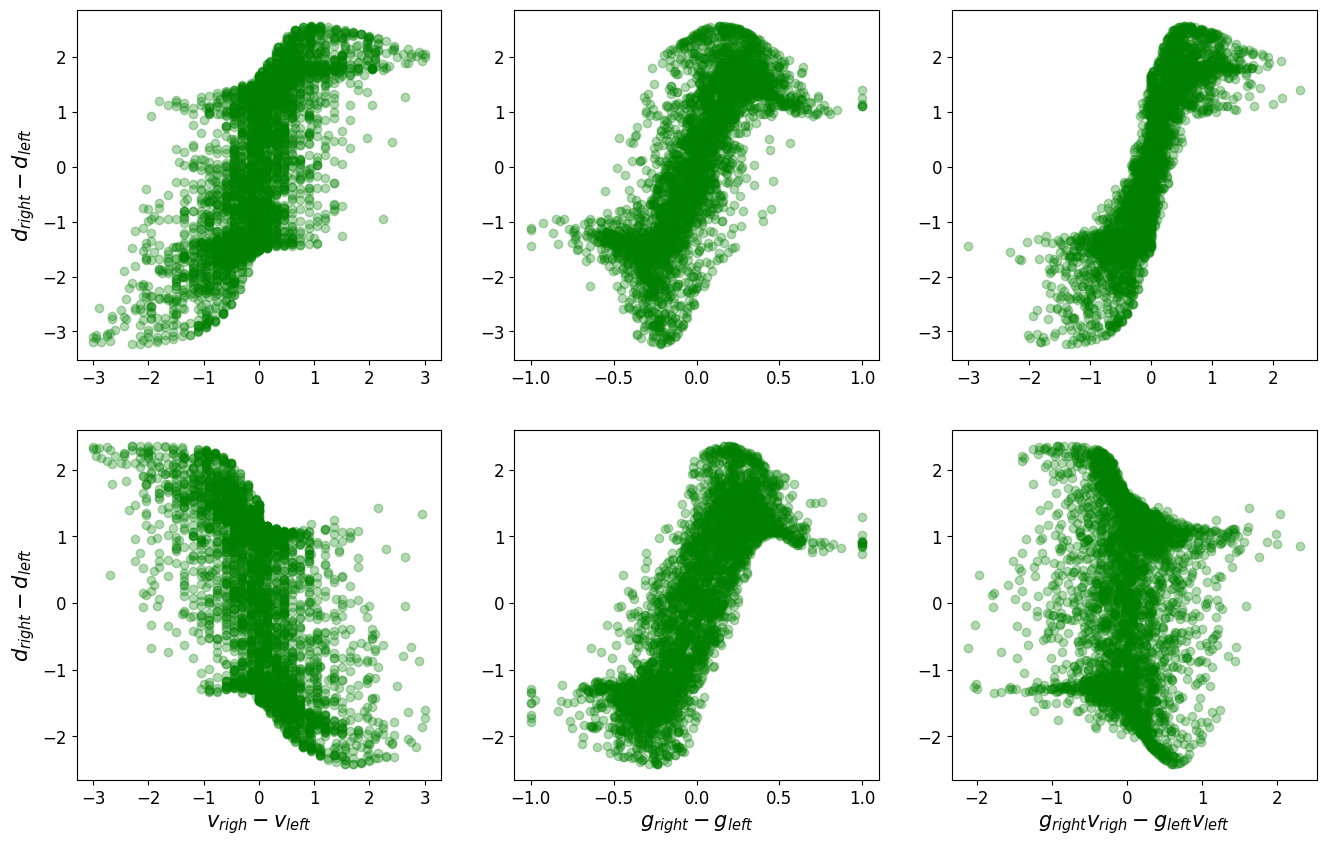

In [14]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 1] - X_test[X_test[:, -1]==1, 0], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');


plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 1] - X_test[X_test[:, -1]==-1, 0], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$v_{righ} - v_{left}$ ');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/sp2020_valuebased_complete_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');